In [1]:
import numpy as np
import torch
from src import kernel_flow, datagen
import tqdm

## Regular Henon

### 1 step

In [2]:
# generate dataset
Data = datagen.Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data
train_data = Data[:600,:].T
test_data = Data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 2
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)
model = kernel_flow.train_kernel(X_train, Y_train, model, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.26it/s]


In [3]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 3

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0000


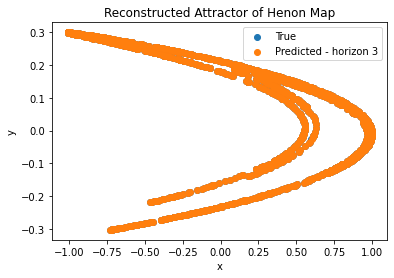

In [4]:
import matplotlib.pyplot as plt
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = f"Predicted - horizon {horizon}")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### n steps interval

In [5]:
n = 3

# generate dataset
Data = datagen.Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data[0::n]
train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model = kernel_flow.train_kernel(X_train, Y_train, model, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.79it/s]


In [6]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0011


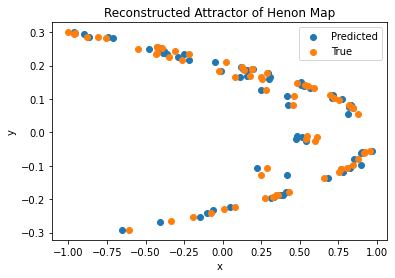

In [7]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## With irregular sampling

In [8]:
max_delay = 3
N_points = 1000
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx/dt)
# generate dataset
Data = datagen.Henon(T=T, dt=dt,N_sims=1,a=1.4,b=0.3)[0]
#train test split

observed_data = Data[indices]

train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model = kernel_flow.train_kernel(X_train, Y_train, model, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.09it/s]


In [9]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.1431


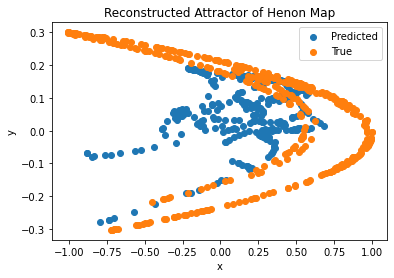

In [10]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## With irregular kernel flow

In [11]:
max_delay = 3
N_points = 1000
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx/dt)
# generate dataset
Data = datagen.Henon(T=T, dt=dt,N_sims=1,a=1.4,b=0.3)[0]
#train test split

observed_data = Data[indices]

train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
delays_train = delays[:600]
delays_test = delays[600:]

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize, delays_test)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model = kernel_flow.train_kernel(X_train, Y_train, model, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.39it/s]


In [12]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0001


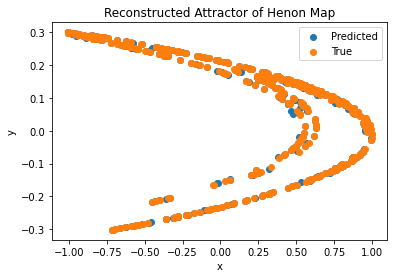

In [13]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Enforcing the semi-group property

In [14]:
max_delay = 3
N_points = 1000
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx/dt)
# generate dataset
Data = datagen.Henon(T=T, dt=dt,N_sims=1,a=1.4,b=0.3)[0]
#train test split

observed_data = Data[indices]

train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
delays_train = delays[:600]
delays_test = delays[600:]

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize, delays_test)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_general", batch_size = False)

model.set_training_data(torch.Tensor(X_train).double(),torch.Tensor(Y_train).double())

In [15]:
model.prepare_semi_group(n_z = 0, max_delay = max_delay)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
verbose = False
print(model.z_tensor)
for i in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    rho = model.forward()
    if rho>=0 and rho<=1:
        rho.backward()
        optimizer.step()
        if verbose:
            print(rho)
print(model.z_tensor)


Parameter containing:
tensor([], size=(0, 2), requires_grad=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.73it/s]

Parameter containing:
tensor([], size=(0, 2), requires_grad=True)


In [17]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 6.1498


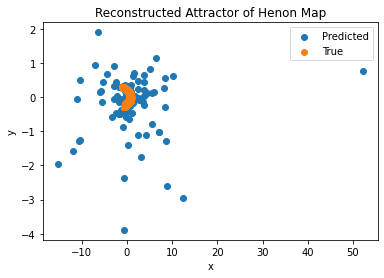

In [18]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()